# Analyse promising candidates

### 2023-11-16 - 2024-04-17 Johannes Sahlmann

- generate Figure 3
- generate several tables

Gaia Data Release 3. Stellar multiplicity, a teaser for the hidden treasure
https://ui.adsabs.harvard.edu/abs/2023A%26A...674A..34G/abstract


Table 11

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import logging
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from pystrometry.utils.archives import get_gaiadr_data
import matplotlib as mp
from pystrometry.utils import du437_tools

# import matplotlib.pyplot as pl

universal_helpers not available


In [2]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
overwrite = False
# overwrite_labelled_list = False
# overwrite_labelled_list = True

# dataset_tag = 'v0.0'
# dataset_tag = 'v0.1'
# dataset_tag = 'v0.4'
dataset_tag = 'v0.6'
data_path = f'/media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_{dataset_tag}'

# plot_dir = '/media/team_workspaces/Gaia-Orbit-Classification/jsahlmann/figures'
plot_dir = os.path.join(data_path, 'figures')
os.makedirs(plot_dir, exist_ok=True)

    

In [4]:
outfile = os.path.join(data_path, 'labelled_sources.parquet')
labelled_sources = pd.read_parquet(outfile)
logging.info(f"Read {len(labelled_sources)} rows from  {outfile}")

INFO:root:Read 1845 rows from  /media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_v0.6/labelled_sources.parquet


In [5]:
labelled_sources['label'].value_counts()
# display(labelled_sources)

label
substellar_companion_candidates           1787
better_substellar_companion_candidates      26
brown_dwarf_companion                       14
exoplanet                                   10
binary_star                                  3
very_low_mass_stellar_companion              3
false_positive_orbit                         2
Name: count, dtype: int64

In [6]:
labelled_sources.columns

Index(['source_id', 'reference', 'label', 'id'], dtype='object')

## Check that these sources are in the provided dataset
### read selected astrometric orbits

In [7]:
outfile = os.path.join(data_path, 'nss_two_body_orbit_astrometric_orbits.parquet')
nss_selected = pd.read_parquet(outfile)

gaia_source = pd.read_parquet(os.path.join(data_path, 'gaia_source_astrometric_orbits.parquet'))
gaia_source = gaia_source.drop_duplicates(subset='source_id')

nss_selected = nss_selected.merge(gaia_source, on='source_id', suffixes=('', '_gaia_source'))

logging.info('Dataset has {} unique source_ids, i.e. {} duplicate source_ids'.format(len(nss_selected['source_id'].unique()), len(nss_selected)-len(nss_selected['source_id'].unique())))
display(nss_selected['nss_solution_type'].value_counts())

INFO:root:Dataset has 169129 unique source_ids, i.e. 0 duplicate source_ids


nss_solution_type
Orbital                           134598
AstroSpectroSB1                    33467
OrbitalAlternative                   619
OrbitalTargetedSearch                339
OrbitalTargetedSearchValidated        96
OrbitalAlternativeValidated           10
Name: count, dtype: int64

In [8]:
assert np.all(labelled_sources['source_id'].isin(nss_selected['source_id']).values)

## remove false positive orbits

In [9]:
remove_false_positives = True
if remove_false_positives:
    nss_selected = nss_selected[~nss_selected['source_id'].isin(labelled_sources.query("label == 'false_positive_orbit'")['source_id'].values)]
    labelled_sources = labelled_sources[~labelled_sources['label'].isin(['false_positive_orbit'])]
    logging.info('Dataset has {} unique source_ids, i.e. {} duplicate source_ids'.format(len(nss_selected['source_id'].unique()), len(nss_selected)-len(nss_selected['source_id'].unique())))


INFO:root:Dataset has 169127 unique source_ids, i.e. 0 duplicate source_ids


In [10]:
# new_candidates = """522135261462534528
# 5266148569447305600
# 2884087104955208064
# 2717981134566374272
# 1897143408911208832
# 3913728032959687424
# 1610837178107032192
# 2047188847334279424""".split('\n')
# new_candidates = np.array(new_candidates).astype(np.int64)
# new_candidates

In [11]:
data_path

'/media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_v0.6'

In [12]:
# new_candidates_all = pd.read_csv(os.path.join(data_path, 'candidates_top50.csv')) #['sourceId']
# candidates_file = os.path.join(data_path, 'candidates_2024-01-10.csv')
# candidates_file = os.path.join(data_path, 'candidates_2024_01_11.csv') # copy of team_workspaces/Gaia-Orbit-Classification/sandbox/results/2024_01_11/candidates.csv
candidates_file = os.path.join(data_path, 'candidates_2024_03_08.csv') 
# candidates_file = os.path.join(data_path, 'candidates_no_rv_error_2024-03-14.csv') 

new_candidates_all = pd.read_csv(candidates_file) #['sourceId']
logging.info(f"Original file contains {len(new_candidates_all)} candidates ({candidates_file})")
assert len(new_candidates_all) == new_candidates_all['source_id'].nunique()
# display(new_candidates_all.info())

INFO:root:Original file contains 227 candidates (/media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_v0.6/candidates_2024_03_08.csv)


In [13]:
# new_candidates_all['relative_occurence'].hist(bins=50, log=True)
# pl.xlabel('relative_occurence')
# pl.title(dataset_tag)
display(new_candidates_all['relative_occurence'].value_counts().sort_index())

relative_occurence
0.125    139
0.250     51
0.375     13
0.500     10
0.625      2
0.750      5
0.875      6
1.000      1
Name: count, dtype: int64

In [14]:
new_candidates_all['label'].value_counts()

label
substellar_companion_candidates           136
better_substellar_companion_candidates      7
Name: count, dtype: int64

In [15]:
new_candidates = new_candidates_all[new_candidates_all['source_id']!=0]
new_candidates = new_candidates[new_candidates['relative_occurence'] > 0.125]
# new_candidates_all
logging.info(f"Cut on relative_occurence > 0.125 leaves {len(new_candidates)} candidates")


INFO:root:Cut on relative_occurence > 0.125 leaves 88 candidates


In [16]:
new_candidates['label'].value_counts()

label
substellar_companion_candidates           66
better_substellar_companion_candidates     7
Name: count, dtype: int64

In [17]:
cols = ['source_id', 'label', 'relative_occurence', 'relative_occurence_ssc', 'relative_occurence_nss']
# new_candidates[cols]

In [18]:
# keep only substellar candidates
# new_candidates = new_candidates[new_candidates['label'].isin(['substellar_companion_candidates', 'better_substellar_companion_candidates'])]
new_candidates = new_candidates[~new_candidates['label'].isin(['very_low_mass_stellar_companion', 'binary_star'])]

new_candidates_ssc = new_candidates[new_candidates['label'].isin(['substellar_companion_candidates', 'better_substellar_companion_candidates'])]
new_candidates_nss = new_candidates[new_candidates['label'].isnull()]
logging.info(f"number of new_candidates_ssc: {len(new_candidates_ssc)}")
logging.info(f"number of new_candidates_nss: {len(new_candidates_nss)}")

new_candidates_ro = new_candidates.query('relative_occurence > 0.5').reset_index(drop=True)
new_candidates_ro_ids = new_candidates_ro['source_id'].values
display(new_candidates_ro[cols])
# print(new_candidates_ro.columns)

# new_candidates_ssc_ids = new_candidates_ssc['source_id'].values
# new_candidates_nss_ids = new_candidates_nss['source_id'].values


new_candidates_ro_ssc = new_candidates.query('relative_occurence_ssc > 0.5').reset_index(drop=True)
new_candidates_ro_ssc = new_candidates_ro_ssc[~new_candidates_ro_ssc['source_id'].isin(new_candidates_ro_ids)]
new_candidates_ro_ssc_ids = new_candidates_ro_ssc['source_id'].values
display(new_candidates_ro_ssc[cols])


new_candidates_ro_nss = new_candidates.query('relative_occurence_nss > 0.5').reset_index(drop=True)
new_candidates_ro_nss = new_candidates_ro_nss[~new_candidates_ro_nss['source_id'].isin(new_candidates_ro_ids)]
new_candidates_ro_nss = new_candidates_ro_nss[~new_candidates_ro_nss['source_id'].isin(new_candidates_ro_ssc_ids)]
new_candidates_ro_nss_ids = new_candidates_ro_nss['source_id'].values
display(new_candidates_ro_nss[cols])


logging.info(f"Cleaned new candidates number: {len(new_candidates)}")
logging.info(f"number of new_candidates_ro: {len(new_candidates_ro)}")
logging.info(f"number of new_candidates_ro_ssc: {len(new_candidates_ro_ssc)}")
logging.info(f"number of new_candidates_ro_nss: {len(new_candidates_ro_nss)}")


new_candidates_all_ids = np.hstack([new_candidates_ro_ids, new_candidates_ro_ssc_ids, new_candidates_ro_nss_ids])
assert len(new_candidates_all_ids) == len(np.unique(new_candidates_all_ids))
len(new_candidates_all_ids)

INFO:root:number of new_candidates_ssc: 73
INFO:root:number of new_candidates_nss: 15


,source_id,label,relative_occurence,relative_occurence_ssc,relative_occurence_nss
0,364792020789523584,substellar_companion_candidates,1.000,1.00,1.00
1,3913728032959687424,substellar_companion_candidates,0.875,1.00,0.75
2,1897143408911208832,substellar_companion_candidates,0.875,1.00,0.75
3,1610837178107032192,substellar_companion_candidates,0.875,1.00,0.75
4,1878822452815621120,substellar_companion_candidates,0.875,1.00,0.75
5,522135261462534528,substellar_companion_candidates,0.875,1.00,0.75
6,2540855308890440064,substellar_companion_candidates,0.875,1.00,0.75
7,3909531609393458688,substellar_companion_candidates,0.750,1.00,0.50
8,1156378820136922880,substellar_companion_candidates,0.750,1.00,0.50
9,2171489736355655680,substellar_companion_candidates,0.750,1.00,0.50


,source_id,label,relative_occurence,relative_occurence_ssc,relative_occurence_nss
13,5484481960625470336,substellar_companion_candidates,0.500,0.75,0.25
14,5323844651848467968,substellar_companion_candidates,0.500,1.00,0.00
15,1576108450508750208,better_substellar_companion_candidates,0.500,1.00,0.00
16,2280560705703031552,substellar_companion_candidates,0.375,0.75,0.00


,source_id,label,relative_occurence,relative_occurence_ssc,relative_occurence_nss
10,3921176983720146560,NaN,0.500,0.0,1.00
11,5148853253106611200,substellar_companion_candidates,0.375,0.0,0.75
12,4545802186476906880,NaN,0.375,0.0,0.75
13,3067074530201582336,NaN,0.375,0.0,0.75


INFO:root:Cleaned new candidates number: 88
INFO:root:number of new_candidates_ro: 14
INFO:root:number of new_candidates_ro_ssc: 4
INFO:root:number of new_candidates_ro_nss: 4


22

In [19]:
# show_second_tier_of_contenders = True
show_second_tier_of_contenders = False
if show_second_tier_of_contenders:
    new_candidates = new_candidates_all[new_candidates_all['source_id']!=0]
    new_candidates = new_candidates[new_candidates['relative_occurence'] > 0.125]
    logging.info(f"Cut on relative_occurence > 0.125 leaves {len(new_candidates)} candidates")
    new_candidates = new_candidates[~new_candidates['source_id'].isin(new_candidates_all_ids)]
    # new_candidates_all
    logging.info(f"Cut on non-duplicates leaves {len(new_candidates)} candidates")
    new_candidates_all_ids = new_candidates['source_id'].values
    
    

In [20]:
# new_candidates_ro_ids.values

In [21]:
new_candidates_all['source_id'].isin(nss_selected['source_id']).value_counts()
# new_candidates_all[new_candidates_all['source_id'].isin(nss_selected['source_id'])==False]

source_id
True    227
Name: count, dtype: int64

In [22]:
# len(nss_selected[nss_selected['source_id'].isin(pd.concat([new_candidates_ro_ids, new_candidates_ro_ssc_ids, new_candidates_ro_nss_ids]))])

In [23]:
# pd.concat([new_candidates_ro_ids, new_candidates_ro_ssc_ids, new_candidates_ro_nss_ids]).sort_values()

In [24]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset


In [25]:
# zoomed_inset_axes?

In [26]:
# len(sel2)

/tmp/ipykernel_2002/815851678.py:120: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=2, colors=['b'], levels = [3], label='substellar companion candidates')


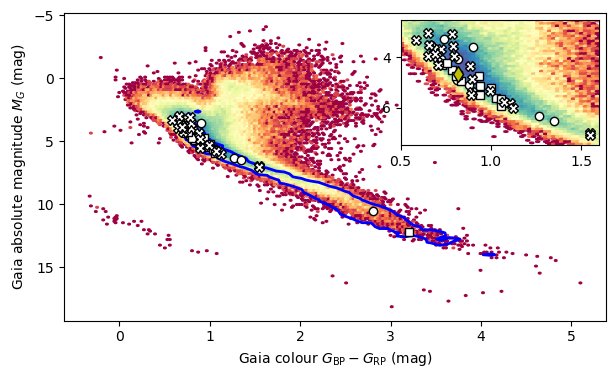

INFO:root:Saving figure to /media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_v0.6/figures/bp_rp_absolute_phot_g_mean_mag_ssc+confirmed.pdf
/tmp/ipykernel_2002/815851678.py:85: RuntimeWarning: divide by zero encountered in log10
  Hmasked = np.log10(Hmasked)
/tmp/ipykernel_2002/815851678.py:104: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(*midpoints, Hmasked, linewidths=2, colors=['b'], levels = [3], label='substellar companion candidates')


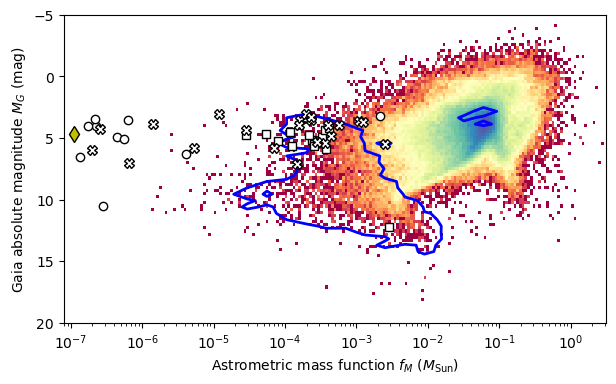

INFO:root:Saving figure to /media/team_workspaces/Gaia-Orbit-Classification/sandbox/dataset_v0.6/figures/mass_function_msun_absolute_phot_g_mean_mag_ssc+confirmed.pdf


In [27]:
sel1 = nss_selected.copy()
sel2 = nss_selected[nss_selected['source_id'].isin(labelled_sources[~labelled_sources['label'].isin(['very_low_mass_stellar_companion', 'binary_star', 'false_positive_orbit'])]['source_id'])]
sel3 = sel2.merge(labelled_sources, on='source_id')
sel4 = sel3[sel3['label'].isin(['brown_dwarf_companion', 'exoplanet'])]
sel5 = nss_selected[nss_selected['source_id'].isin(new_candidates)]
# sel6 = nss_selected[nss_selected['source_id'].isin([3230836376154368384, 3573773434382465280, 1055017523232004352, 6795834500861297408, 5557776367807067648, 4361277334741236480, 4869246209213679872])]
sel7 = nss_selected[nss_selected['source_id'].isin(new_candidates_ssc)]
sel8 = nss_selected[nss_selected['source_id'].isin(new_candidates_nss)]
sel9 = nss_selected[nss_selected['source_id'].isin(new_candidates_ro)]
sel10 = nss_selected[nss_selected['source_id'].isin(new_candidates_ro_ssc)]
# sel11 = nss_selected[nss_selected['source_id'].isin(pd.concat([new_candidates_ro, new_candidates_ro_ssc]))]
sel11 = nss_selected[nss_selected['source_id'].isin(new_candidates_all_ids)]
sel12 = sel3[sel3['label'].isin(['exoplanet'])]
sel13 = sel3[sel3['label'].isin(['brown_dwarf_companion'])]

title = None

colour_by = 'bp_rp'
# colour_by = 'mass_function_msun'
norm = mp.colors.LogNorm()
colormap='rainbow'


plot_option = 'all'
# plot_option = 'nss-only'
# plot_option = 'ssc'
# plot_option = 'confirmed'
# plot_option = 'confirmed+candidate'

for x_col in ['bp_rp', 'mass_function_msun']:
# for x_col in ['bp_rp']:
    # x_col = 'bp_rp'
    # x_col = 'mass_function_msun'
    y_col = 'absolute_phot_g_mean_mag'


    from collections import OrderedDict
    datasets = OrderedDict()
    datasets[0] = {'label': f'all ({len(sel1)})', 'data': sel1, 'color': 'k'}
    datasets[1] = {'label': f'substellar candidates ({len(sel2)})', 'data': sel2, 'color': '0.7'}
    datasets[2] = {'label': f'confirmed BD-companions and exoplanets ({len(sel4)})', 'data': sel4, 'color': 'r'}
    # datasets[3] = {'label': f'new candidates ({len(sel5)})', 'data': sel5, 'color': 'b'}
    # datasets[4] = {'label': f'new_candidates_ssc ({len(sel7)})', 'data': sel7, 'color': 'y'}
    # datasets[5] = {'label': f'new_candidates_nss ({len(sel8)})', 'data': sel8, 'color': 'b'}
    datasets[6] = {'label': f'new_candidates_ro ({len(sel9)})', 'data': sel9, 'color': 'b'}
    datasets[7] = {'label': f'new_candidates_ro_ssc ({len(sel10)})', 'data': sel10, 'color': 'g'}
    datasets[8] = {'label': f'Substellar contenders ({len(sel11)})', 'data': sel11, 'color': 'k'}
    datasets[12] = {'label': f'Confirmed exoplanets ({len(sel12)})', 'data': sel12, 'color': 'k'}
    datasets[13] = {'label': f'Confirmed BD-companions ({len(sel13)})', 'data': sel13, 'color': 'k'}


    fig = pl.figure(figsize=(7,4))
    x = datasets[1]['data'][x_col]
    y = datasets[1]['data'][y_col]
    if x_col == 'mass_function_msun':
        bins = [np.logspace(-8, -1, 30), np.linspace(0, 15, 30)]
    else:
        bins=50

    counts,xbins,ybins,image = pl.hist2d(x,y,bins=bins)
    pl.close()

    # for plot_option in ['all', 'nss-only', 'ssc', 'confirmed', 'confirmed+candidate', 'ssc+confirmed']:
    for plot_option in ['ssc+confirmed']:

        fig = pl.figure(figsize=(7,4))
        ax = pl.gca()



        # datasets[4] = {'label': f'SED IR-excess ({len(sel6)})', 'data': sel6}
        colormap = "Spectral"
        if x_col == 'bp_rp':
            datasets[0]['data'].plot(x_col, y_col, kind='hexbin', gridsize=(200, 100), ax=ax, label=datasets[0]['label'], bins='log', cmap=colormap, colorbar=False)#, cmap="Greys")#, **kwargs)  # , c='parallax'

        elif x_col == 'mass_function_msun':
            df = datasets[0]['data']
            x = df[x_col].values
            y = df[y_col].values
            bins2 = [np.logspace(-7.1, 0.5, 200), np.linspace(-5, 20, 100)]
            H, xedges, yedges = np.histogram2d(x,y,bins=bins2)
            H = np.rot90(H)
            H = np.flipud(H)
            Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
            Hmasked = np.log10(Hmasked)

            pl.pcolormesh(xedges,yedges,Hmasked,cmap=colormap)
            cbar = pl.colorbar()
            cbar.remove()
            ax.set_xscale('log') 

            if x_col == 'mass_function_msun':
                df = datasets[1]['data']
                x = df[x_col].values
                y = df[y_col].values
                bins2 = [np.logspace(-8, 0, 30), np.linspace(0, 15, 30)]
                H, xe, ye = np.histogram2d(x,y,bins=bins2)
                H = np.rot90(H)
                H = np.flipud(H)
                # Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
                # Hmasked = np.log10(Hmasked)
                Hmasked = H
                midpoints = (xe[1:] + xe[:-1])/2, (ye[1:] + ye[:-1])/2
                ax.contour(*midpoints, Hmasked, linewidths=2, colors=['b'], levels = [3], label='substellar companion candidates')

                # pl.pcolormesh(xedges,yedges,Hmasked,cmap='Greys')
                # cbar = pl.colorbar()
                # cbar.remove()
                # ax.set_xscale('log') 



        # datasets[0]['data'].plot(x_col, y_col, kind='hexbin', gridsize=(200, 100), ax=ax, label=datasets[0]['label'], bins='log', cmap="Spectral", extent=[0, 2 ,-5,20])#, cmap="Greys")#, **kwargs)  # , c='parallax'

        if plot_option in ['all', 'ssc', 'ssc+confirmed']:
            # datasets[1]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[1]['label'], colormap='rainbow', c='0.7', s=5)#, **kwargs)  # , c='parallax'
            # datasets[1]['data'].plot(x_col, y_col, kind='kde', ax=ax, label=datasets[1]['label'])#, **kwargs)  # , c='parallax'

            if x_col == 'bp_rp':
                ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=2, colors=['b'], levels = [3], label='substellar companion candidates')
            # else:    
            #     ax.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]], linewidths=2, colors=['b'], levels = [1])
                # ax.contour(counts.transpose(), linewidths=2, colors=['b'], levels = [2])



        if plot_option in ['all', 'confirmed', 'confirmed+candidate']:
            datasets[2]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[2]['label'], c='k', s=30)#, **kwargs)  # , c='parallax'
        # datasets[3]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[3]['label'], c='r', s=30)#, **kwargs)  # , c='parallax'
        # datasets[3]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[3]['label'], c='r', s=30)#, **kwargs)  # , c='parallax'
        # datasets[4]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[4]['label'], c=datasets[4]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[5]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[5]['label'], c=datasets[5]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[6]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[6]['label'], c=datasets[6]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[7]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[7]['label'], c=datasets[7]['color'], s=30)#, **kwargs)  # , c='parallax'        

        if plot_option in ['all', 'confirmed+candidate', 'ssc+confirmed']:
            # datasets[8]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[8]['label'], c=datasets[8]['color'], s=30)#, **kwargs)  # , c='parallax'

            x = datasets[12]['data'][x_col]
            y = datasets[12]['data'][y_col]
            pl.plot(x, y, marker='o', mfc='w', mec=datasets[12]['color'], ms=6, label=datasets[12]['label'], ls='None')
            x = datasets[13]['data'][x_col]
            y = datasets[13]['data'][y_col]
            pl.plot(x, y, marker='s', mfc='w', mec=datasets[13]['color'], ms=6, label=datasets[13]['label'], ls='None')

            x = datasets[8]['data'][x_col]
            y = datasets[8]['data'][y_col]
            # if x_col == 'mass_function_msun':
            #     # pass
            #     pl.plot(x, y, marker='X', mfc='w', ms=8, mec='k', label=datasets[8]['label'], ls='None')
            # else:
            pl.plot(x, y, marker='X', mfc='w', ms=7, mec='k', label=datasets[8]['label'], ls='None')
                # pl.plot(x, y, marker='x', c='k', ms=5, label=datasets[8]['label'], ls='None')


        # datasets[4]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[4]['label'], c='b', s=30)#, **kwargs)  # , c='parallax'
        # ax.set_title('{} ({} sources)'.format(title, len(sel1)))
        ax.invert_yaxis()


        # sel1.nss.plot_cmd(title='Substellar-companion candidates', c=colour_by, colormap=colormap, ax=ax)
        # sel1.nss.plot_cmd()
        # ax.set_xlabel('$G_\mathrm{BP}-G_\mathrm{RP}$')
        # ax.set_ylabel('$M_G$')
        if x_col == 'mass_function_msun':
            ax.set_xlabel('Astrometric mass function $f_M$ ($M_\mathrm{Sun}$)')
        else:    
            ax.set_xlabel('Gaia colour $G_\mathrm{BP}-G_\mathrm{RP}$ (mag)')
        ax.set_ylabel('Gaia absolute magnitude $M_G$ (mag)')

        # ax.legend(loc=4)
        
        if x_col == 'bp_rp':
            axins = zoomed_inset_axes(ax, 2, loc=1) # zoom = 6
            x1, x2, y1, y2 = 0.5, 1.6, 2.5, 7.5
            datasets[0]['data'].query(f"{x_col} > {x1} and {x_col} < {x2} and {y_col} > {y1} and {y_col} < {y2}").plot(x_col, y_col, kind='hexbin', gridsize=(50, 50), ax=axins, label=datasets[0]['label'], bins='log', cmap=colormap, colorbar=False)
            # axins.imshow(Z2, extent=extent, interpolation="nearest", origin="lower")

            # sub region of the original image
            # x1, x2, y1, y2 = 0, 2, 3, 7
            axins.set_xlim(x1, x2)
            axins.set_ylim(y1, y2)
            axins.invert_yaxis()
            axins.set_ylabel('')
            axins.set_xlabel('')
            x = datasets[12]['data'][x_col]
            y = datasets[12]['data'][y_col]
            axins.plot(x, y, marker='o', mfc='w', mec=datasets[12]['color'], ms=6, label=datasets[12]['label'], ls='None')
            x = datasets[13]['data'][x_col]
            y = datasets[13]['data'][y_col]
            axins.plot(x, y, marker='s', mfc='w', mec=datasets[13]['color'], ms=6, label=datasets[13]['label'], ls='None')

            x = datasets[8]['data'][x_col]
            y = datasets[8]['data'][y_col]
            # axins.plot(x, y, marker='x', c='k', ms=5, label=datasets[8]['label'], ls='None')
            axins.plot(x, y, marker='X', c='k', ms=7, mfc='w', label=datasets[8]['label'], ls='None')

            axins.plot(0.82, 4.67, marker='d', c='k', mfc='y', ms=8, label='Sun', ls='None')
            # axins.set_yticks(visible=False)
        else:
            ax.plot(1.1e-7, 4.67, marker='d', c='k', mfc='y', ms=8, label='Sun', ls='None')

        
        pl.show()

        saveplot = True
        if saveplot:
            figure_file_name = os.path.join(plot_dir, f'{x_col}_{y_col}_{plot_option}.pdf')
            logging.info('Saving figure to {}'.format(figure_file_name))
            fig.savefig(figure_file_name, transparent=True, bbox_inches='tight', pad_inches=0.05)


In [28]:
# import matplotlib.pyplot as plt

# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
# from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# import numpy as np

# def get_demo_image():
#     from matplotlib.cbook import get_sample_data
#     import numpy as np
#     f = get_sample_data("axes_grid/bivariate_normal.npy", asfileobj=False)
#     z = np.load(f)
#     # z is a numpy array of 15x15
#     return z, (-3,4,-4,3)

# fig, ax = plt.subplots(figsize=[5,4])

# # prepare the demo image
# Z, extent = get_demo_image()
# Z2 = np.zeros([150, 150], dtype="d")
# ny, nx = Z.shape
# Z2[30:30+ny, 30:30+nx] = Z

# # extent = [-3, 4, -4, 3]
# ax.imshow(Z2, extent=extent, interpolation="nearest",
#           origin="lower")

# axins = zoomed_inset_axes(ax, 6, loc=1) # zoom = 6
# axins.imshow(Z2, extent=extent, interpolation="nearest",
#              origin="lower")

# # sub region of the original image
# x1, x2, y1, y2 = -1.5, -0.9, -2.5, -1.9
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)

# plt.xticks(visible=False)
# plt.yticks(visible=False)

# # draw a bbox of the region of the inset axes in the parent axes and
# # connecting lines between the bbox and the inset axes area
# mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

# plt.draw()
# plt.show()

In [29]:
print(sel4[['source_id', 'label', 'id', 'bp_rp', 'mass_function_msun']].sort_values('bp_rp', ascending=False).to_string())

                source_id                  label          id     bp_rp  mass_function_msun
1072    43574131143039104  brown_dwarf_companion     LHS1610  3.202310        2.857490e-03
1755  2603090003484152064              exoplanet       GJ876  2.809284        2.803763e-07
1181  2367734656180397952              exoplanet  BD−170063   1.346591        1.335989e-07
786   4062446910648807168              exoplanet    HD164604  1.267999        4.078758e-06
1646  5563001178343925376  brown_dwarf_companion     HD52756  1.058083        2.505084e-04
1110   685029558383335168  brown_dwarf_companion     HD77065  1.057203        3.705910e-04
1561  2651390587219807744  brown_dwarf_companion   BD−004475  1.029741        1.243255e-04
1372  3750881083756656128  brown_dwarf_companion     HD91669  1.001240        7.989367e-05
1349  5999024986946599808  brown_dwarf_companion  CD-4610046  0.942402        2.573752e-04
276    873616860770228352  brown_dwarf_companion  BD+291539   0.938650        2.369071e-04

In [30]:
# sel11.columns

In [31]:
print(sel11[['source_id', 'bp_rp', 'absolute_phot_g_mean_mag', 'mass_function_msun']].sort_values('bp_rp', ascending=False).to_string())

                  source_id     bp_rp  absolute_phot_g_mean_mag  mass_function_msun
51009   5148853253106611200  1.548269                  7.078447        1.459385e-04
9776    1712614124767394816  1.546817                  7.003759        6.448643e-07
74622   2884087104955208064  1.124158                  6.006632        1.946441e-07
60403   6330529666839726592  1.106186                  5.815082        7.070740e-05
98041   1878822452815621120  1.073614                  5.785907        5.353743e-06
117130  2540855308890440064  0.993631                  5.331594        2.784526e-04
152526  3909531609393458688  0.896022                  4.847577        4.379791e-04
54600   1156378820136922880  0.895697                  5.373438        3.609783e-04
165150  3067074530201582336  0.891760                  5.506566        2.493937e-03
134313  1897143408911208832  0.881879                  4.336407        2.805161e-05
93509   5484481960625470336  0.793957                  3.925828        1.587

In [32]:
df = datasets[0]['data']
cols = ['source_id', 'nss_solution_type', 'absolute_phot_g_mean_mag', 'bp_rp', 'mass_function_msun']
tmp = df[(df['mass_function_msun'] < 2e-6) & (df['absolute_phot_g_mean_mag'] > 8)][cols]
display(tmp)
print(tmp.to_string(index=False))



,source_id,nss_solution_type,absolute_phot_g_mean_mag,bp_rp,mass_function_msun
2353,557717892980808960,Orbital,9.036476,2.384589,1.725227e-06
19868,246890014559489792,Orbital,10.781160,2.913510,1.366972e-06
154037,4702845638429469056,Orbital,9.753196,2.368413,1.590876e-06
161725,2603090003484152064,OrbitalTargetedSearchValidated,10.527513,2.809284,2.803763e-07


          source_id              nss_solution_type  absolute_phot_g_mean_mag    bp_rp  mass_function_msun
 557717892980808960                        Orbital                  9.036476 2.384589        1.725227e-06
 246890014559489792                        Orbital                 10.781160 2.913510        1.366972e-06
4702845638429469056                        Orbital                  9.753196 2.368413        1.590876e-06
2603090003484152064 OrbitalTargetedSearchValidated                 10.527513 2.809284        2.803763e-07


In [33]:
# df.columns

In [34]:
# fig = pl.figure(figsize=(8,5))
# ax = pl.gca()

# # datasets[1]['data'].plot(x_col, y_col, kind='kde', ax=ax, label=datasets[1]['label'])#, **kwargs)  # , c='parallax'

# from matplotlib.colors import LogNorm
# from matplotlib.pyplot import *

# x = datasets[1]['data'][x_col]
# y = datasets[1]['data'][y_col]
# # counts,ybins,xbins,image = hist2d(x,y,bins=20,norm=LogNorm())
# # contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
# # pl.show()


# from matplotlib.colors import LogNorm
# import matplotlib.pyplot as plt

# # x = np.random.normal(5,10,100000)
# # y = np.random.normal(5,10,100000)
# pl.subplot(121)
# counts,xbins,ybins,image = pl.hist2d(x,y,bins=50)
# pl.colorbar()
# pl.subplot(122)
# pl.contour(counts.transpose(),extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],
#     linewidths=3, cmap = pl.cm.rainbow, levels = [2])


In [35]:
# np.max(counts)

In [36]:
if 0:
    def plot_density_histogram(df, x_col, y_col):


        x = df[x_col].values/(u.year.to(u.day))
        y = df[y_col].values

        # https://oceanpython.org/2013/02/25/2d-histogram/
        # Estimate the 2D histogram
        nbins = 200
        bins = [np.logspace(-2, 2, 200), np.logspace(-30, 0, 100)]
        H, xedges, yedges = np.histogram2d(x,y,bins=bins)

        # # H needs to be rotated and flipped
        H = np.rot90(H)
        H = np.flipud(H)

        # Mask zeros
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero

        Hmasked = np.log10(Hmasked)
        # Plot 2D histogram using pcolor
        fig = pl.figure(figsize=(8,4))
        ax = pl.gca()
        # selected.plot('p1_period_year', 'p1_a1_mas', kind='scatter', logx=True, logy=True, ax=ax, color='k', label=f'{len(selected)}')

        # fig = pl.figure()
        # ax = pl.gca()
        pl.pcolormesh(xedges,yedges,Hmasked,cmap='hot')
        pl.axvline(1, ls=':', zorder=-51)
        pl.axvline(1/2, ls=':', zorder=-51)
        # pl.axvline(1*2, ls=':', zorder=-51)

        # df_select.plot('period_year', 'fap', kind='scatter', logx=True, logy=True, ax=ax, color='k', marker='*', s=100)
        # pl.xlim((2e-2, 60))
        # pl.ylim((1e-1, 1e4))
        pl.xlabel('Orbital period (year)')
        pl.ylabel('Periodogram FAP')
        cbar = pl.colorbar()
        # cbar.ax.set_ylabel('Counts')
        cbar.remove()
        ax.set_yscale('log') 
        ax.set_xscale('log') 
        pl.show()




In [37]:

if 0:
    sel1 = nss_selected.copy()
    # sel2 = nss_selected[nss_selected['source_id'].isin(labelled_sources['source_id'])]
    # sel3 = sel2.merge(labelled_sources, on='source_id')
    # sel4 = sel3[sel3['label'].isin(['brown_dwarf_companion', 'exoplanet'])]
    # sel5 = nss_selected[nss_selected['source_id'].isin(new_candidates)]
    # # sel6 = nss_selected[nss_selected['source_id'].isin([3230836376154368384, 3573773434382465280, 1055017523232004352, 6795834500861297408, 5557776367807067648, 4361277334741236480, 4869246209213679872])]
    # sel7 = nss_selected[nss_selected['source_id'].isin(new_candidates_ssc)]
    # sel8 = nss_selected[nss_selected['source_id'].isin(new_candidates_nss)]
    # sel9 = nss_selected[nss_selected['source_id'].isin(new_candidates_ro)]
    # sel10 = nss_selected[nss_selected['source_id'].isin(new_candidates_ro_ssc)]
    # sel11 = nss_selected[nss_selected['source_id'].isin(pd.concat([new_candidates_ro, new_candidates_ro_ssc]))]

    title = None

    colour_by = 'bp_rp'
    # colour_by = 'mass_function_msun'
    norm = mp.colors.LogNorm()
    colormap='rainbow'
    colormap="Spectral"


    # plot_option = 'all'
    # plot_option = 'nss-only'
    # plot_option = 'ssc'
    # plot_option = 'confirmed'
    # plot_option = 'confirmed+candidate'

    # x_col = 'bp_rp'
    x_col = 'mass_function_msun'
    y_col = 'absolute_phot_g_mean_mag'

    # for plot_option in ['all', 'nss-only', 'ssc', 'confirmed', 'confirmed+candidate', 'ssc+confirmed']:
    for plot_option in ['confirmed']:

        fig = pl.figure(figsize=(8,5))
        ax = pl.gca()

        from collections import OrderedDict
        datasets = OrderedDict()
        datasets[0] = {'label': f'all ({len(sel1)})', 'data': sel1, 'color': 'k'}
        datasets[1] = {'label': f'substellar candidates ({len(sel2)})', 'data': sel2, 'color': '0.7'}
        datasets[2] = {'label': f'confirmed BD-companions and exoplanets ({len(sel4)})', 'data': sel4, 'color': 'r'}
        # datasets[3] = {'label': f'new candidates ({len(sel5)})', 'data': sel5, 'color': 'b'}
        # datasets[4] = {'label': f'new_candidates_ssc ({len(sel7)})', 'data': sel7, 'color': 'y'}
        # datasets[5] = {'label': f'new_candidates_nss ({len(sel8)})', 'data': sel8, 'color': 'b'}
        datasets[6] = {'label': f'new_candidates_ro ({len(sel9)})', 'data': sel9, 'color': 'b'}
        datasets[7] = {'label': f'new_candidates_ro_ssc ({len(sel10)})', 'data': sel10, 'color': 'g'}
        datasets[8] = {'label': f'best-candidate BD-companions and exoplanets ({len(sel11)})', 'data': sel11, 'color': 'b'}
        # datasets[4] = {'label': f'SED IR-excess ({len(sel6)})', 'data': sel6}

        # datasets[0]['data'].plot(x_col, y_col, kind='hexbin', gridsize=(200, 100), ax=ax, label=datasets[0]['label'], bins='log', cmap="Spectral")#, cmap="Greys")#, **kwargs)  # , c='parallax'
        # datasets[0]['data'].plot(x_col, y_col, kind='hexbin', gridsize=(200, 100), ax=ax, label=datasets[0]['label'], bins='log', cmap="Spectral", extent=[0, 2 ,-5,20])#, cmap="Greys")#, **kwargs)  # , c='parallax'

        df = datasets[0]['data']
        x = df[x_col].values
        y = df[y_col].values
        nbins = 200
        # bins = [np.logspace(-7, 2, 200), np.logspace(-30, 0, 100)]
        bins = [np.logspace(-7, 2, 200), np.linspace(-5, 20, 100)]
        H, xedges, yedges = np.histogram2d(x,y,bins=bins)
        H = np.rot90(H)
        H = np.flipud(H)
        Hmasked = np.ma.masked_where(H==0,H) # Mask pixels with a value of zero
        Hmasked = np.log10(Hmasked)

        # fig = pl.figure(figsize=(8,4))
        # ax = pl.gca()
        # selected.plot('p1_period_year', 'p1_a1_mas', kind='scatter', logx=True, logy=True, ax=ax, color='k', label=f'{len(selected)}')

        # fig = pl.figure()
        # ax = pl.gca()
        pl.pcolormesh(xedges,yedges,Hmasked,cmap=colormap)
        # pl.axvline(1, ls=':', zorder=-51)
        # pl.axvline(1/2, ls=':', zorder=-51)
        # pl.axvline(1*2, ls=':', zorder=-51)

        # df_select.plot('period_year', 'fap', kind='scatter', logx=True, logy=True, ax=ax, color='k', marker='*', s=100)
        # pl.xlim((2e-2, 60))
        # pl.ylim((1e-1, 1e4))
        # pl.xlabel('Orbital period (year)')
        # pl.ylabel('Periodogram FAP')
        cbar = pl.colorbar()
        # cbar.ax.set_ylabel('Counts')
        cbar.remove()
        # ax.set_yscale('log') 
        ax.set_xscale('log') 




        if plot_option in ['all', 'ssc', 'ssc+confirmed']:
            datasets[1]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[1]['label'], colormap='rainbow', c='0.7', s=5)#, **kwargs)  # , c='parallax'
        if plot_option in ['all', 'confirmed', 'confirmed+candidate', 'ssc+confirmed']:
            datasets[2]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[2]['label'], c='k', s=50, marker = 'o', facecolors='w')#, **kwargs)  # , c='parallax'
        # datasets[3]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[3]['label'], c='r', s=30)#, **kwargs)  # , c='parallax'
        # datasets[3]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[3]['label'], c='r', s=30)#, **kwargs)  # , c='parallax'
        # datasets[4]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[4]['label'], c=datasets[4]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[5]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[5]['label'], c=datasets[5]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[6]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[6]['label'], c=datasets[6]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[7]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[7]['label'], c=datasets[7]['color'], s=30)#, **kwargs)  # , c='parallax'
        if plot_option in ['all', 'confirmed+candidate']:
            datasets[8]['data'].plot(x_col, y_col, kind='scatter', ax=ax, label=datasets[8]['label'], c=datasets[8]['color'], s=30)#, **kwargs)  # , c='parallax'
        # datasets[4]['data'].plot('bp_rp', 'absolute_phot_g_mean_mag', kind='scatter', ax=ax, label=datasets[4]['label'], c='b', s=30)#, **kwargs)  # , c='parallax'
        # ax.set_title('{} ({} sources)'.format(title, len(sel1)))
        ax.invert_yaxis()


        # sel1.nss.plot_cmd(title='Substellar-companion candidates', c=colour_by, colormap=colormap, ax=ax)
        # sel1.nss.plot_cmd()
        # ax.set_xlabel('$G_\mathrm{BP}-G_\mathrm{RP}$')
        # ax.set_ylabel('$M_G$')
        ax.set_xlabel(x_col)
        ax.set_ylabel(y_col)

        ax.legend()
        pl.show()

        saveplot = False
        if saveplot:
            figure_file_name = os.path.join(plot_dir, f'cmd_{plot_option}.pdf')
            logging.info('Saving figure to {}'.format(figure_file_name))
            fig.savefig(figure_file_name, transparent=True, bbox_inches='tight', pad_inches=0.05)


In [38]:
pd.set_option('display.max_columns', 600)
pd.set_option('display.max_rows', 100)
# sel_new_candidates = sel2[sel2['source_id'].isin(new_candidates_all_ids)]
sel_new_candidates = sel11
# sel_new_candidates

In [39]:
# new_candidates_nss

In [40]:
sel_new_candidates['source_id'].nunique()

22

In [41]:
# sel7

In [42]:
# sel8

In [43]:
if 0:
    fig = pl.figure()
    ax = pl.gca()
    col = 'mass_function_msun'
    # col = 'phot_g_mean_mag'
    # col = 'absolute_phot_g_mean_mag'
    # col = 'phot_bp_mean_mag'
    # col = 'phot_rp_mean_mag'
    col = 'radial_velocity_error'
    # col = 'goodness_of_fit'
    bins = np.logspace(-5,1,100)
    logx = True
    log = True

    if 'phot_g_mean_mag' == col:
        bins = np.linspace(-6,20,100)
        logx=False    
    elif 'mean_mag' in col:
        bins = np.linspace(-6,20,100)
        logx=False
    elif 'radial_velocity_error' in col:
        # bins = np.logspace(-1,2,100)
        bins = np.linspace(0.1, 1,30)
        logx=False

    for key, dataset in datasets.items():
        sel = dataset['data']
        label = dataset['label']
        color = dataset['color'] 
        # if 'BD ' in label:
        #     histtype = 'stepfilled'
        # else:        
        histtype = 'step'

        #     continue

    # for sel in [sel1, sel2, sel4, sel5]:    
        sel[col].plot(kind='hist', histtype=histtype, logx=logx, bins=bins, lw=2, ax=ax, log=log, label=label, color=color)
    # sel2[col].plot(kind='hist', histtype='step', logx=logx, bins=bins, lw=2, ax=ax, log=True, label='Solutions without mass estimate', color='g')
    # nss_selected[col].plot(kind='hist', histtype='step', logx=logx, bins=bins, lw=2, ax=ax, log=True, label='all solutions', color='0.7')

    # sel3 = nss_selected[nss_selected['source_id'].isin(labelled_sources[labelled_sources['label'].isin(['exoplanet', 'brown_dwarf_companion'])]['source_id'])]
    # sel3[col].plot(kind='hist', histtype='step', logx=logx, bins=bins, lw=2, ax=ax, log=True, label='Exoplanets & BD companions', color='b')

    ax.set_xlabel(col)
    pl.legend(loc=2)
    pl.show()

### plot rv_error as function of mass_function  and include gMag

In [44]:
import os
from astropy.table import Table
from astroquery.simbad import Simbad
from astroquery.gaia import Gaia
import numpy as np


class AstroSource(object):
    """Class for astronomical sources.

    Notes
    -----
        from astroquery.simbad import Simbad
        Simbad.list_votable_fields()
    """

    def __init__(self, identifier):
        self.identifier = identifier

    def __repr__(self):
        return '<AstroSource object id={0}>'.format(self.identifier)

    def set_simbad_fields(self, simbad_id, out_dir, overwrite=False,
                          votable_fields=('ra(d)', 'dec(d)', 'pmdec', 'pmra', 'parallax', 'sptype', 'ids')):
        """Retrieve source information from Simbad.

        Parameters
        ----------
        simbad_id
        out_dir
        overwrite
        votable_fields

        Returns
        -------

        """

        out_file = os.path.join(out_dir, '{}_simbad_parameters.txt'.format(self.identifier))
        if (not (os.path.isfile(out_file))) | overwrite:
            if os.path.isdir(out_dir) is False:
                os.makedirs(out_dir)
            simb = Simbad()
            if votable_fields is not None:
                simb.add_votable_fields(*votable_fields)
            pt = simb.query_object(simbad_id)
            pt.write(out_file, format='ascii.basic', delimiter=',')
        else:
            pt = Table.read(out_file, format='ascii.basic', delimiter=',')

        for c in pt.colnames:
            try:
                setattr(self, c, pt[c][0])
            except:
                setattr(self, c, None)


    def set_gaia_source_id(self):
        """Add the Gaia source_id attribute."""

        if hasattr(self, 'IDS') is False:
            raise RuntimeError('RUN set_simbad_fields() first!')
        try:
            self.simbad_identifiers = self.IDS.decode().split('|')
        except AttributeError:
            self.simbad_identifiers = self.IDS.split('|')

        self.gaia_dr2_id = None
        self.gaia_dr1_id = None
        try:
            self.gaia_dr2_id = [np.int(id.split(' ')[2].replace("'", "").replace("\"", "")) for id in self.simbad_identifiers if 'Gaia DR2 ' in id][0]
        except IndexError:
            try:
                self.gaia_dr1_id = [id for id in self.simbad_identifiers if 'Gaia DR1 ' in id][0]
            except IndexError:
                print('No Gaia identifier listed in Simbad!')


    def add_gaia(self):
        """Retrieve and add Gaia DR2 or DR1 parameters."""

        if hasattr(self, 'IDS') is False:
            raise RuntimeError('RUN set_simbad_fields() first!')
        try:
            self.simbad_identifiers = self.IDS.decode().split('|')
        except AttributeError:
            self.simbad_identifiers = self.IDS.split('|')

        try:
            gaia_dr2_id = [id for id in self.simbad_identifiers if 'Gaia DR2 ' in id][0].replace("'", "")
            # print(gaia_dr2_id)
            gacs_query = "SELECT * FROM gaiadr2.gaia_source WHERE source_id={}".format(gaia_dr2_id.split(' ')[-1])
            job = Gaia.launch_job_async(gacs_query)
            self.gaiadr2_table = job.get_results()
        except IndexError:
            try:
                gaia_dr1_id = [id for id in self.simbad_identifiers if 'Gaia DR1 ' in id][0]
                # return_gacs_query_as_table(query_string, output_file_seed, overwrite=False, verbose=True):
                gacs_query = "SELECT * FROM gaiadr1.gaia_source WHERE source_id={}".format(gaia_dr1_id.split(' ')[-1])
                job = Gaia.launch_job_async(gacs_query)
                self.gaiadr1_table = job.get_results()
            except IndexError:
                print('No Gaia identifier listed in Simbad!')


In [45]:
simbad_dir = '/media/team_workspaces/Gaia-Orbit-Classification/jsahlmann/data/simbad'
os.makedirs(simbad_dir, exist_ok=True)

simbad_sources = {}

for sid in sel_new_candidates['source_id']:
    # if sid != 5773484949857279104:
    #     continue
    simbad_id = f"Gaia DR3 {sid}"
    # 1/0
    astro_source = AstroSource(simbad_id)
    try:
        astro_source.set_simbad_fields(simbad_id, simbad_dir)
    except AttributeError:
        print(sid)
        # setattr(astro_source, 'MAIN_ID', sid)

    astro_source.latex_url = f"\href{{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+{sid}&submit=SIMBAD+search}}{{{getattr(astro_source, 'MAIN_ID', sid)}}}" 
    simbad_sources[sid] = astro_source
    
    
sel_new_candidates['name'] = [getattr(simbad_sources[sid], 'latex_url') for sid in sel_new_candidates['source_id']]    
sel_new_candidates['SpT'] = [getattr(simbad_sources[sid], 'SP_TYPE', 'N/A') for sid in sel_new_candidates['source_id']]    
sel_new_candidates['MAIN_ID'] = [getattr(simbad_sources[sid], 'MAIN_ID', 'N/A') for sid in sel_new_candidates['source_id']]    



2540855308890440064


/home/jsahlman/.conda/envs/gorbit/lib/python3.9/site-packages/astroquery/simbad/core.py:135: UserWarning: Warning: The script line number 3 raised an error (recorded in the `errors` attribute of the result table): Identifier not found in the database : Gaia DR3 2540855308890440064
  warnings.warn("Warning: The script line number %i raised "
/tmp/ipykernel_2002/3226240793.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sel_new_candidates['name'] = [getattr(simbad_sources[sid], 'latex_url') for sid in sel_new_candidates['source_id']]
/tmp/ipykernel_2002/3226240793.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

In [46]:
sel_new_candidates = sel_new_candidates.nss.add_companion_mass_estimate()

/home/jsahlman/.conda/envs/gorbit/lib/python3.9/site-packages/pystrometry/utils/du437_tools.py:519: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._obj['m2_MJ'] = m2_kg / pystrometry.MJ_kg
/home/jsahlman/.conda/envs/gorbit/lib/python3.9/site-packages/pystrometry/utils/du437_tools.py:520: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._obj['m2_MS'] = m2_kg / pystrometry.MS_kg
/home/jsahlman/.conda/envs/gorbit/lib/python3.9/site-packages/pystrometry/utils/du437_tools.py:521: SettingWithCopyWarning: 
A

In [47]:
sel_new_candidates = sel_new_candidates.merge(new_candidates_all, on='source_id')

In [48]:
# sel_new_candidates.columns

In [49]:
cols = ['source_id', 'MAIN_ID', 'SpT', 'nss_solution_type', 'period', 'mass_function_msun', 'm2_MJ', 'relative_occurence', 'absolute_phot_g_mean_mag', 'bp_rp', 'relative_occurence']
cols += ['relative_occurence_ssc', 'relative_occurence_nss']
# display(sel_new_candidates.sort_values('absolute_phot_g_mean_mag')[cols])

In [50]:
# cols = ['source_id', 'name', 'SpT', 'nss_solution_type', 'period', 'mass_function_msun', 'm2_MJ', 'relative_occurence']
cols = ['source_id', 'name', 'SpT', 'nst', 'period', 'mass_function_msun', 'm2_MJ', 'relative_occurence']
cols += ['relative_occurence_ssc', 'relative_occurence_nss', 'is_ssc']
sel_new_candidates['nst'] = sel_new_candidates['nss_solution_type'].replace({'OrbitalTargetedSearchValidated':'OTSV', 'OrbitalTargetedSearch':'OTS', 'AstroSpectroSB1': 'ASB1'})

In [51]:
col2 = sel_new_candidates.columns

In [52]:
# sel_new_candidates.query('source_id == 5773484949857278976')

In [53]:
# tmp3 = sel_new_candidates.query('relative_occurence > 0.5').sort_values('mass_function_msun')[cols].reset_index(drop=True)
# print(tmp3.to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))


# for paper!

In [54]:
show_second_tier_of_contenders

False

In [55]:
if show_second_tier_of_contenders is False:
    # substellar contenders
    tmp3 = sel_new_candidates.query('relative_occurence > 0.5').sort_values('mass_function_msun')[col2].reset_index(drop=True)
    # print(tmp3.to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

    tmp4 = sel_new_candidates.query('relative_occurence_nss > 0.5').sort_values('mass_function_msun')[col2].reset_index(drop=True)
    tmp4 = tmp4[~tmp4['source_id'].isin(tmp3['source_id'])]
    # print(tmp4.to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

    tmp5 = sel_new_candidates.query('relative_occurence_ssc > 0.5').sort_values('mass_function_msun')[col2].reset_index(drop=True)
    tmp5 = tmp5[~tmp5['source_id'].isin(tmp4['source_id'])]
    tmp5 = tmp5[~tmp5['source_id'].isin(tmp3['source_id'])]
    # print(tmp5.reset_index(drop=True).to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))


    tmp_all = pd.concat([tmp3, tmp4, tmp5.reset_index(drop=True)])
    # print(tmp_all[cols].to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format, ))
    # print(len(tmp_all))

else:
    tmp3 = sel_new_candidates.sort_values('mass_function_msun')[col2].reset_index(drop=True)

#     tmp4 = sel_new_candidates.query('relative_occurence_nss > 0.5').sort_values('mass_function_msun')[col2].reset_index(drop=True)
#     tmp4 = tmp4[~tmp4['source_id'].isin(tmp3['source_id'])]
#     # print(tmp4.to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

#     tmp5 = sel_new_candidates.query('relative_occurence_ssc > 0.5').sort_values('mass_function_msun')[col2].reset_index(drop=True)
#     tmp5 = tmp5[~tmp5['source_id'].isin(tmp4['source_id'])]
#     tmp5 = tmp5[~tmp5['source_id'].isin(tmp3['source_id'])]
#     # print(tmp5.reset_index(drop=True).to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

    tmp_all = tmp3.copy()
    # tmp_all = pd.concat([tmp3, tmp4, tmp5.reset_index(drop=True)])
    
tmp_all['is_ssc'] = tmp_all['source_id'].isin(labelled_sources[labelled_sources['label'].isin(['substellar_companion_candidates', 'better_substellar_companion_candidates'])]['source_id']).astype(int)    
print(tmp_all[cols].to_latex(index=True, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format, ))
print(len(tmp_all))

# check that all candidates are from the preselected sources    
assert labelled_sources[labelled_sources['source_id'].isin(tmp_all['source_id'])]['label'].isin(['substellar_companion_candidates', 'better_substellar_companion_candidates']).all()    

\begin{tabular}{lrlllrrrrrrr}
\toprule
 & source_id & name & SpT & nst & period & mass_function_msun & m2_MJ & relative_occurence & relative_occurence_ssc & relative_occurence_nss & is_ssc \\
\midrule
0 & 2884087104955208064 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+2884087104955208064&submit=SIMBAD+search}{HD  40503} & K2/3V & OTSV & 826.5 & 1.9e-07 & 6.1 & 0.8 & 0.8 & 0.8 & 1 \\
1 & 522135261462534528 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+522135261462534528&submit=SIMBAD+search}{*  54 Cas} & F8 & OTS & 401.1 & 2.5e-07 & 6.6 & 0.9 & 1.0 & 0.8 & 1 \\
2 & 1712614124767394816 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+1712614124767394816&submit=SIMBAD+search}{BD+75   510} & M0V & OTSV & 297.6 & 6.4e-07 & 9.1 & 0.8 & 0.8 & 0.8 & 1 \\
3 & 1610837178107032192 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+1610837178107032192&submit=SIMBAD+search}{HD 128717} & F8 & OTS & 1089.2 & 1.4e-06 & 11.8 

In [56]:


# labelled_sources[labelled_sources['source_id'].isin(tmp_all['source_id'])]['label'].isin(['substellar_companion_candidates', 'better_substellar_companion_candidates']).astype(int)

In [57]:
# sel_new_candidates

In [58]:
# query archive
root_data_dir = '/media/team_workspaces/Gaia-Orbit-Classification/jsahlmann/data'
gaia_data_release = 'gaiadr3'
input_list_name = 'nss'
data_dir = os.path.join(root_data_dir, gaia_data_release)
# plot_dir = os.path.join(data_dir, 'figures', input_list_name)

gaia_table_name='binary_masses'
analysis_dataset_name = '{}_all'.format(gaia_table_name)

binary_masses = get_gaiadr_data(analysis_dataset_name, data_dir, gaia_data_release=gaia_data_release, gaia_table_name=gaia_table_name)

Retrieved 195315 rows from gaiadr3.binary_masses


In [59]:
tmp_bm = binary_masses[binary_masses['source_id'].isin(tmp_all['source_id'])].reset_index(drop=True)
# print(len(tmp_bm))



tmp_bm['$M_1$'] = tmp_bm.apply(lambda x: f"${{{x['m1']:2.2f}}}^{{+{x['m1_upper']-x['m1']:2.2f}}}_{{-{x['m1']-x['m1_lower']:2.2f}}}$", axis=1)

def m2_latex(x):
    if np.isnan(x['m2']):
        return f"${x['m2_lower']:2.3f}$-${x['m2_upper']:2.3f}$"
    else:
        return f"${{{x['m2']:2.3f}}}^{{+{x['m2_upper']-x['m2']:2.3f}}}_{{-{x['m2']-x['m2_lower']:2.3f}}}$"

tmp_bm['$M_{2, \mathrm{alt}}$'] = tmp_bm.apply(m2_latex, axis=1)


# display(tmp_bm)
best_contenders = tmp_all.merge(tmp_bm, on='source_id', how='outer')

best_contenders['m1_MS'] = [m if ~np.isnan(m) else 1.0 for m in best_contenders['m1']]
# best_contenders['$M_1$'] = [m if ~np.isnan(m) else 1.0 for m in best_contenders['$M_1$']]
best_contenders = best_contenders.nss.add_companion_mass_estimate(m1_MS=None)
print(len(best_contenders))


cols2 = cols + ['$M_1$', '$M_{2, \mathrm{alt}}$']

# print(best_contenders[best_contenders['source_id']==5323844651848467968]['m2_MJ'])
print(best_contenders[cols2].to_latex(index=False, formatters={'source_id': "{:d}".format, 'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format, ))


# display(best_contenders[best_contenders['source_id']==5323844651848467968].iloc[0])

INFO:root:using column m1_MS values to compute companion mass


22
\begin{tabular}{rlllrrrrrrrll}
\toprule
source_id & name & SpT & nst & period & mass_function_msun & m2_MJ & relative_occurence & relative_occurence_ssc & relative_occurence_nss & is_ssc & $M_1$ & $M_{2, \mathrm{alt}}$ \\
\midrule
2884087104955208064 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+2884087104955208064&submit=SIMBAD+search}{HD  40503} & K2/3V & OTSV & 826.5 & 1.9e-07 & 5.2 & 0.8 & 0.8 & 0.8 & 1 & ${0.79}^{+0.05}_{-0.23}$ & $0.004$-$0.681$ \\
522135261462534528 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+522135261462534528&submit=SIMBAD+search}{*  54 Cas} & F8 & OTS & 401.1 & 2.5e-07 & 7.1 & 0.9 & 1.0 & 0.8 & 1 & ${1.09}^{+0.06}_{-0.31}$ & $0.005$-$0.905$ \\
1712614124767394816 & \href{http://simbad.u-strasbg.fr/simbad/sim-basic?Ident=Gaia+DR3+1712614124767394816&submit=SIMBAD+search}{BD+75   510} & M0V & OTSV & 297.6 & 6.4e-07 & 7.3 & 0.8 & 0.8 & 0.8 & 1 & ${0.71}^{+0.05}_{-0.20}$ & $0.006$-$0.632$ \\
1610837178107032192 & \hr

In [60]:
# (best_contenders['$M_1$'])

In [61]:
display(tmp_bm.iloc[0])

tmp_bm['$M_1$'] = tmp_bm.apply(lambda x: f"${x['m1']:2.2f}^{x['m1_upper']-x['m1']:+2.2f}_{x['m1']-x['m1_lower']:+2.2f}$", axis=1)

def m2_latex(x):
    if np.isnan(x['m2']):
        return f"${x['m2_lower']:+2.3f}$ -- ${x['m2_upper']:+2.3f}$"
    else:
        return f"${x['m2']:2.3f}^{x['m2_upper']-x['m2']:+2.3f}_{x['m2']-x['m2_lower']:+2.3f}$"

tmp_bm['$M_{2, \mathrm{alt}}$'] = tmp_bm.apply(m2_latex, axis=1)

source_id                     5484481960625470336
m1                                       1.022197
m1_lower                                 0.939945
m1_upper                                 1.080575
m2                                            NaN
m2_lower                                 0.051613
m2_upper                                 1.261184
fluxratio                                     NaN
fluxratio_lower                               0.0
fluxratio_upper                               1.0
combination_method                     Orbital+M1
m1_ref                                    IsocLum
flag                                             
$M_1$                    ${1.02}^{+0.06}_{-0.08}$
$M_{2, \mathrm{alt}}$             $0.052$-$1.261$
Name: 0, dtype: object

In [62]:
best_contenders['m1_MS'] = best_contenders['m1']
# display(best_contenders[['m1_MS', 'm2_MJ']])
best_contenders = best_contenders.nss.add_companion_mass_estimate(m1_MS=None)
display(best_contenders[['m1_MS', 'm2_MJ']])


INFO:root:using column m1_MS values to compute companion mass


,m1_MS,m2_MJ
0,0.794231,5.228521
1,1.094448,7.052491
2,0.711354,7.258940
3,1.128043,12.767899
4,0.823652,16.305048
5,0.993087,32.336522
6,0.815953,38.966536
7,1.209616,67.180762
8,1.161372,73.759265
9,1.277747,78.619660


In [63]:
1/0

ZeroDivisionError: division by zero

In [ ]:
tmp4['source_id'].values

In [ ]:
final_new_candidates = np.hstack((tmp3['source_id'].values, tmp5['source_id'].values))
len(final_new_candidates)

In [ ]:
# tmp4 = sel_new_candidates.query('relative_occurence_nss > 0.5').sort_values('mass_function_msun')[cols].reset_index(drop=True)
# # tmp4 = tmp4[~tmp4['source_id'].isin(tmp3['source_id'])]
# print(tmp4.to_latex(index=True, formatters={'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))


In [ ]:
# print(sel_new_candidates.sort_values('mass_function_msun')[cols].to_latex(index=False, formatters={'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

# tmp1 = sel_new_candidates.query('relative_occurence > 0.5').sort_values('mass_function_msun')[cols].reset_index(drop=True)
# print(tmp1.to_latex(index=True, formatters={'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))
# tmp2 = sel_new_candidates.query('relative_occurence < 0.5').sort_values('mass_function_msun')[cols].reset_index(drop=True)
# print(tmp2.to_latex(index=True, formatters={'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))
# print(sel_new_candidates.sort_values('mass_function_msun')[cols].to_latex(index=False, formatters={'mass_function_msun': "{:.1e}".format}, float_format="{:.1f}".format))

In [ ]:
sel_new_candidates.columns

In [ ]:
sid

In [ ]:
getattr(astro_source, 'MAIN_ID')

In [ ]:
astro_source.__dict__